#  Ошибки 1 и 2 рода

Что мы сделаем 

- оценим ошибки первого и второго рода для теста о доле с помощью симуляций
- посмотрим на то, как можно рассчитать число наблюдений необходимое для конкретных величин ошибок

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels as sts 
from tqdm.notebook import tqdm

plt.style.use('ggplot')

## Симулируем ошибки 1 и 2 рода 

Проверка гипотезы о равенстве доли $p = p_0$  на уровне значимости $\alpha$.

$$
\begin{aligned}
&H_0: \hspace{2mm} p = 0.5 \\
&H_1: \hspace{2mm} p > 0.5 
\end{aligned}
$$

Для этого нам понадобится статистика:

$$
z=\frac{p-p_{0}}{\sqrt{\dfrac{p_{0}\left(1-p_{0}\right)}{n}}}\sim N\left(0,\ 1\right)
$$



In [2]:
def prop_asy_test(x, p0=0.5, alpha=0.05):
    p = x.mean()
    z_obs = (p - p0)/np.sqrt(p0*(1-p0)/x.size)
    pval = 1 - stats.norm.cdf(z_obs)  # p-value
    return pval

__Уровень значимости (ошибка первого рода)__ - вероятность отвергнуть гипотезу $H_0$, когда она верна. 

Попробуем с помощью симуляций вычислить её для проверки гипотезы о среднем.

Когда мы проверяем гипотезу, мы фиксируем уровень значимости. Давайте убедимся, что он действительно оказывается таким, каким мы его зафиксировали.

In [3]:
n_obs = 10**5 
res = np.zeros(n_obs)

bern_rv = stats.bernoulli(p=0.5)

for i in tqdm(range(n_obs)):
    x = bern_rv.rvs(100)
    res[i] = prop_asy_test(x)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [4]:
np.mean(res < 0.05) 

0.04304

__Ошибка второго рода__ - вероятность не отвергнуть гипотезу $H_0$, когда она неверна.

Ошибку второго рода мы минимизируем по остаточному принципу. 

Давайте узнаем какого размера она в нашем эксперименте.

In [5]:
n_obs = 10**5 
res = np.zeros(n_obs)

bern_rv = stats.bernoulli(p=0.6)

for i in tqdm(range(n_obs)):
    x = bern_rv.rvs(100)
    res[i] = prop_asy_test(x)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [6]:
np.mean(res > 0.05)

0.37703

Ошибка второго рода зашкаливает. Если увеличить число наблюдений, она уменьшится. Давайте научимся подбирать число наблюдений так, чтобы ошибка второго рода была такой, какой мы хотим. 

## Ошибка 2 рода и число наблюдений

Можно вывести формулу, описывающую как ошибка второго рода зависит от числа наблюдений и ошибки первого рода. 

Давайте немного подробнее посмотрим как эти три величины зависят друг от друга. 


Для простой альтернативы $(p = p_a)$:

$$
\beta = \Phi \left( \frac{\sqrt{\frac{p_0 \cdot (1 - p_0)}{n}}}{\sqrt{\frac{p_a \cdot (1 - p_a)}{n}}} \cdot z_{1 - \alpha} +  \frac{p_0 - p_a}{\sqrt{\frac{p_a \cdot (1 - p_a)}{n}}} \right),
$$

где $\Phi(x)$ - функция распределения для $N(0,1)$. Нарисуем это.

In [7]:
alpha = np.arange(0,1,0.001)[1:]       # уровень значимости, который мы фиксируем
z_alpha = stats.norm().ppf(1 - alpha)  # разные критические значения

# наша ситуация
p0 = 0.5
pa = 0.6  # если изменить алтернативу, кривые изменятся
n = 100   # если выборка больше, гипотезы более различимы

sd0 = np.sqrt(p0*(1-p0)/n)
sda = np.sqrt(pa*(1-pa)/n)

beta = stats.norm().cdf(sd0/sda * z_alpha + (p0 - pa)/sda)

In [8]:
alpha[49], beta[49]

(0.05, 0.35850051272836425)

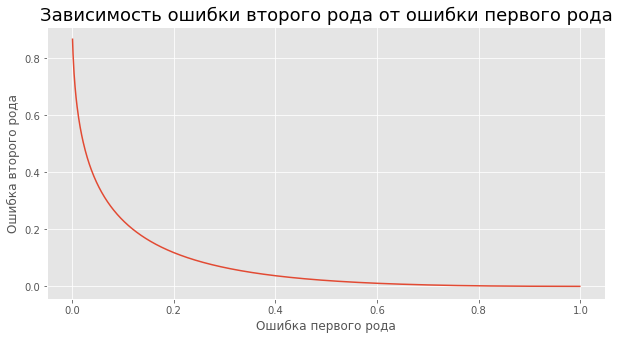

In [9]:
plt.figure(figsize = (10, 5))

plt.plot(alpha, beta)
plt.title("Зависимость ошибки второго рода от ошибки первого рода", fontsize=18)
plt.xlabel("Ошибка первого рода")
plt.ylabel("Ошибка второго рода");

In [28]:

alpha = 0.05
betas = []
for n in np.linspace(10, 2000, 100):
    z_alpha = stats.norm().ppf(1 - alpha)  # разные критические значения
    # наша ситуация
    p0 = 0.5
    pa = 0.55  # если изменить алтернативу, кривые изменятся

    sd0 = np.sqrt(p0*(1-p0)/n)
    sda = np.sqrt(pa*(1-pa)/n)

    beta = stats.norm().cdf(sd0/sda * z_alpha + (p0 - pa)/sda)
    betas.append(beta)

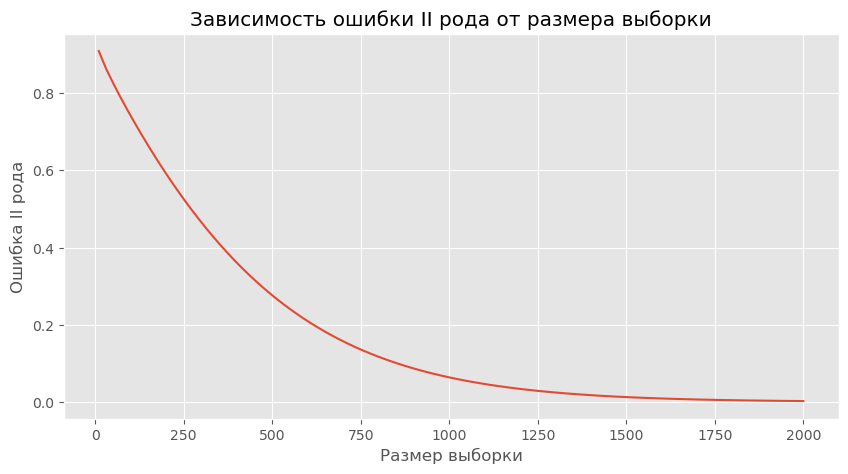

In [29]:
plt.figure(figsize = (10, 5))
plt.plot(np.linspace(10, 2000, 100), betas);
plt.xlabel('Размер выборки')
plt.ylabel('Ошибка II рода')
plt.title('Зависимость ошибки II рода от размера выборки');

In [30]:

alpha = 0.05
betas = []
for pa in np.linspace(0.5, 0.8, 100):
    z_alpha = stats.norm().ppf(1 - alpha)  # разные критические значения
    # наша ситуация
    p0 = 0.5
#     pa = 0.51  # если изменить алтернативу, кривые изменятся
    n = 100

    sd0 = np.sqrt(p0*(1-p0)/n)
    sda = np.sqrt(pa*(1-pa)/n)

    beta = stats.norm().cdf(sd0/sda * z_alpha + (p0 - pa)/sda)
    betas.append(beta)

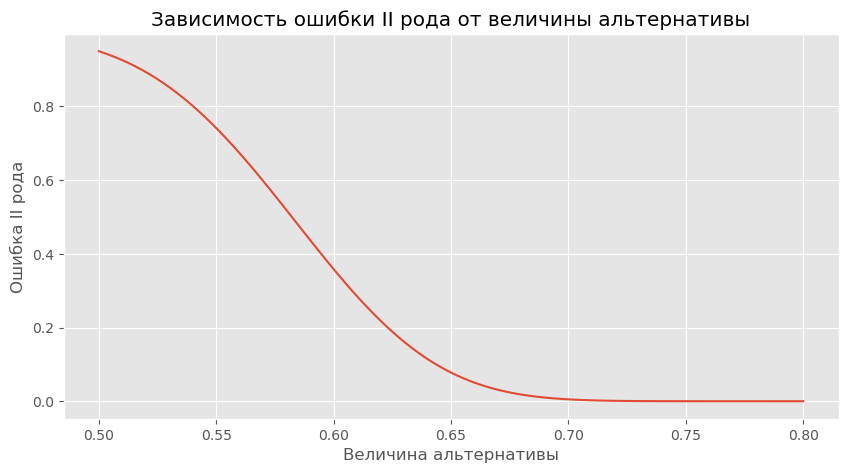

In [31]:
plt.figure(figsize = (10, 5))
plt.plot(np.linspace(0.5, 0.8, 100), betas)
plt.xlabel('Величина альтернативы')
plt.ylabel('Ошибка II рода')
plt.title('Зависимость ошибки II рода от величины альтернативы');

Посмотрим на то как ошибки зависят друг от друга в зависимости от выбора критического значения.

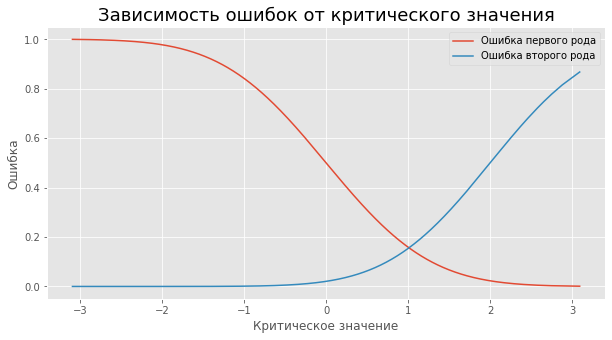

In [10]:
plt.figure(figsize = (10, 5))

plt.plot(z_alpha, alpha, label = "Ошибка первого рода")
plt.plot(z_alpha, beta, label = "Ошибка второго рода")
plt.title("Зависимость ошибок от критического значения", fontsize=18)

plt.xlabel("Критическое значение")
plt.ylabel("Ошибка")
plt.legend();

In [11]:
m = z_alpha<1.96
z_alpha[m][0], alpha[m][0], beta[m][0]

# при критическом значении 1.96 ошибка 1го рода - 0.025, а 2го рода – 0.483

(1.959963984540054, 0.025, 0.4837031204258197)

> __Выводы:__ Видно, что ошибка первого и второго рода взаимосвязаны. Чем ниже ошибка первого рода, тем выше ошибка второго рода. Чем выше критическое значение, тем ниже ошибка первого рода, но тем выще ошибка второго рода. Между этими двумя ошибками надо искать баланс. 



Посмотрим на конкретную величину $\beta$ при $\alpha = 0.05$. И наоборот. 

In [12]:
beta[alpha == 0.05]

array([0.35850051])

In [13]:
ind = np.argmin(np.abs(beta - 0.05)) # beta наиболее близкая к 5%
alpha[ind]

0.34900000000000003

Если мы увеличим количество наблюдений, ошибка второго рода уменьшится. Формула, по которой это происходит: 

$$
n = \left( \frac{\sqrt{p_0 \cdot (1 - p_0) } \cdot z_{1 - \alpha} + \sqrt{p_a \cdot (1 - p_a) } \cdot z_{1 - \beta} }{p_a - p_0}  \right)^2
$$

Напишем функцию, которая по конкретным $p_a$, $\alpha$ и $\beta$ говорит нам сколько наблюдений нужно собрать.

In [14]:
def find_n(p0, pa, alpha=0.05, beta=0.05):
    za = stats.norm().ppf(1 - alpha)
    zb = stats.norm().ppf(1 - beta)
    sn = (np.sqrt(p0*(1 - p0))* za + np.sqrt(pa*(1 - pa))* zb)/(pa - p0)
    return sn**2

In [15]:
find_n(0.5, 0.6, alpha=0.05, beta=0.05)

265.11564803989296

In [16]:
find_n(0.5, 0.6, alpha=0.01, beta=0.01)

530.3104250795232

In [17]:
find_n(0.5, 0.51, alpha=0.01, beta=0.01)

54108.11998038348

- Чем меньше ошибки 1/2 рода, тем больше наблюдений нам нужно
- Чем ниже размер эффекта, который мы хотим детектировать $p_0 - p_a$, тем больше наблюдений нам нужно

__Ситуация:__ 

Менеджер Алексей хочет проверить правда ли Джеймс Бонд отличает взболтанный мартини от смешанного. Алексей полагает, что если Бонд правда умеет различать напитки, то размер эффекта должен быть как минимум $0.2$. Алексей хотел бы получить ошибки первого и второго рода равные 1%. Сколько наблюдений ему нужно? 

In [18]:
find_n(0.5, 0.7, alpha=0.01, beta=0.01)

124.23782566566618

На практике перед запуском эксперимента обычно готовят табличку, в которой смотрят на то, сколько наблюдений понадобится для поиска эффекта разного размера при разных значениях ошибок первого и второго рода.

**Выводы**

- Ошибка 1 и 2 рода конфликтуют друг с другом. Обычно когда понижаешь одну из ошибок, растёт другая. 
- Зная как вычисляется ошибка второго рода, можно прикидывать сколько нам надо собрать наблюдений, чтобы та оказалась меньше некоторого порога.
- __Борьба за мощность:__ найти тест, обладающей наибольшей мощностью (наименьшей ошибкой второго рода) при фиксированной ошибке первого рода